# 🚜 In this notebook, the goal of this machine learning project is to predict sale price of bulldozers

## 1. Problem Statement
> How well can we predict the sale price of a bulldozer, given its characteristics and previously sold bulldozer prices with similar features ?

## 2. Data
> The data being used here directly comes from the Kaggle competition: Bluebook for Bulldozers : https://www.kaggle.com/c/bluebook-for-bulldozers/data

> The dataset is split into 3 parts:
* `Train.csv` is the training set, which contains data through the end of 2011.
* `Valid.csv` is the validation set, which contains data from January 1, 2012 - April 30, 2012.
* `Test.csv` is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012.

## 3. Evaluation
> The evaluation metric for this competition is the `RMSLE` (root mean squared log error) between the actual and predicted auction prices. https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

## 4. Features
> Kaggle provides a data dictionary detailing about all the features of the dataset. Check here: https://docs.google.com/spreadsheets/d/1nr5fa6adQk794TsNd0RMXLsxiaDJdWzd_pxQe6GjWoo/edit?usp=sharing

In [1]:
# import all libs/tools we need
# EDA and plotting libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# model evaluations
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.metrics import plot_roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import training and validation sets

df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [3]:
# check for null values

df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

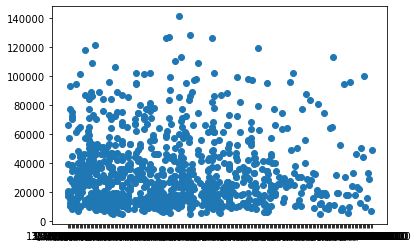

In [4]:
# plot saledate and saleprice 
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000]);

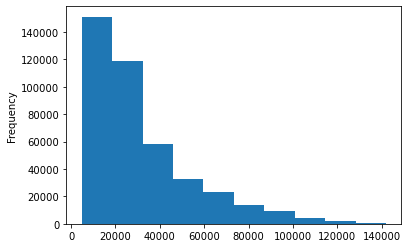

In [5]:
# distribution of saleprice

df.SalePrice.plot(kind='hist');

### Parsing Dates
> When working with time series data, enrich time & date components as much as possible.

In [6]:
df.saledate

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

In [7]:
# import data again but this time parse_dates as well

df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv',
                parse_dates=['saledate'])

In [8]:
df.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

### Sort Dataframe by saledate
> When working with `Time-Series` data, should format data by date.



In [9]:
# Sort data by saledate

df.sort_values(by=['saledate'],
              ascending=True,
              inplace=True)
df.saledate

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
            ...    
410879   2012-04-28
412476   2012-04-28
411927   2012-04-28
407124   2012-04-28
409203   2012-04-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

In [10]:
# Keep copy of data

df_tmp = df.copy()

### Feature Engineering

#### Add Date time parameters for `saleDate` column

In [11]:
# enrich dataframe with multiple date time components

# year
df['saleYear'] = df.saledate.dt.year
df['saleMonth'] = df.saledate.dt.month
df['saleDay'] = df.saledate.dt.day
df['saleDayofWeek'] = df.saledate.dt.dayofweek
df['saleDayofYear'] = df.saledate.dt.dayofyear
df['saleQuarterOfYear'] = df.saledate.dt.quarter

In [12]:
# since we have enriched our dataframe with date time attributes
# saledate can be dropped
df.drop(columns=['saledate'],
       inplace=True)

In [13]:
# Check sales as per states
df.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

# 5. Modelling
> Since we have too many features, Let's do some model driven EDA


In [14]:
# Let's build a ML model

clf = RandomForestRegressor(n_jobs=-1,
                           random_state=42)
# clf.fit(df.drop(columns=['SalePrice']), df['SalePrice'])


# This shows that we need to convert Data into numerical format
# AND ALSO
# Fix all the Null/missing values

### Convert String/Object Data to Numericals

In [15]:
# Check which all columns are string/object or similar types
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(f"{label}")

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


### Convert String to categories
> One way to deal with non-numeric data is to convert them to `Categories`

In [16]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype('category').cat.as_ordered()

In [17]:
# export categoriesed data
df.to_csv('data/bluebook-for-bulldozers/train_categorized.csv',
         index=False)

In [18]:
df = pd.read_csv('data/bluebook-for-bulldozers/train_categorized.csv')
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofWeek,saleDayofYear,saleQuarterOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17,1
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,Standard,Conventional,1989,1,31,1,31,1
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31,1
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,Standard,Conventional,1989,1,31,1,31,1
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,PAT,Lever,NaN,NaN,1989,1,31,1,31,1


In [19]:
# Let's see what percent of values are missing for different columns
df.isnull().sum()/len(df) < 0.8

SalesID                      True
SalePrice                    True
MachineID                    True
ModelID                      True
datasource                   True
auctioneerID                 True
YearMade                     True
MachineHoursCurrentMeter     True
UsageBand                   False
fiModelDesc                  True
fiBaseModel                  True
fiSecondaryDesc              True
fiModelSeries               False
fiModelDescriptor           False
ProductSize                  True
fiProductClassDesc           True
state                        True
ProductGroup                 True
ProductGroupDesc             True
Drive_System                 True
Enclosure                    True
Forks                        True
Pad_Type                    False
Ride_Control                 True
Stick                       False
Transmission                 True
Turbocharged                False
Blade_Extension             False
Blade_Width                 False
Enclosure_Type

### Fill Missing Values
#### Fill Numeric missing values
> Always prefer to use `median` as compared to mean to fill missing values

In [20]:
"""
    Find Numeric columns with missing values and fill them with median
"""
def fillNumericCols(dataframe = df):
    missingValCols = []
    for label, content in df.items():
        # check if numeric
        if pd.api.types.is_numeric_dtype(content):
            missingValCols.append(label)
            # create a binary column for tracking
            # AND check if Null values are there or Not
            dataframe[label+'_is_missing'] = pd.isnull(content)
            # fill missing value by median
            dataframe[label] = content.fillna(content.median())
    return dataframe, missingValCols

In [21]:
df, missingValCols = fillNumericCols(df)

In [22]:
df.shape

(412698, 72)

In [23]:
# check if any more null values present ?

df[missingValCols].isnull().sum()

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
saleYear                    0
saleMonth                   0
saleDay                     0
saleDayofWeek               0
saleDayofYear               0
saleQuarterOfYear           0
dtype: int64

In [24]:
df.isnull().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
saleMonth_is_missing            0
saleDay_is_missing              0
saleDayofWeek_is_missing        0
saleDayofYear_is_missing        0
saleQuarterOfYear_is_missing    0
Length: 72, dtype: int64

In [25]:
# Let's now fill other cols with null values

"""
    Find Non Numeric CATEGORICAL columns with missing values and fill them 
"""
def fillCols(dataframe = df):
    missingValCols = []
    for label, content in df.items():
        # check if Non Numeric
        if not pd.api.types.is_numeric_dtype(content):
            missingValCols.append(label)
            # create a binary column for tracking
            # AND check if Missing values are there or Not
            dataframe[label+'_is_missing'] = pd.isnull(content)
            # Non numeric CATEGORICAL columns with Missing values are assigned -1 Category code by default
            # Hence, incrementing category code
            dataframe[label] = pd.Categorical(content).codes +1
    return dataframe, missingValCols

In [26]:
df, missingValCols = fillCols(df)

In [27]:
# check for any other Null values, if present ?

df.isnull().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 116, dtype: int64

### Since, there aren't any missing values and all the data is numeric
### >>> Build & Fit our Machine Learning model

In [28]:
len(df)

412698

In [29]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [30]:
%%time

# Initialize and fit a model
clf = RandomForestRegressor(n_jobs=-1,
                           random_state=42)
clf.fit(df.drop(columns=['SalePrice']), df['SalePrice'])

CPU times: user 12min 33s, sys: 7.66 s, total: 12min 40s
Wall time: 1min 52s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [31]:
# score the model (Not on Training Data)
clf.score(df.drop(columns=['SalePrice']), df['SalePrice'])


0.9875522516344091

* NOT AT ALL RELIABLE - EVALUATION DONE ON TRAINING DATA



### Splitting Data into Training and Validation Sets

In [32]:
train_df = df[df['saleYear'] < 2012]
valid_df = df[df['saleYear'] >= 2012]

In [33]:
train_df.shape, valid_df.shape

((401125, 116), (11573, 116))

In [34]:
X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice']
X_valid, y_valid = valid_df.drop(columns=['SalePrice']), valid_df['SalePrice']

In [35]:
%%time

# Training the model on TRAINING dataset
clf = RandomForestRegressor(n_jobs=-1,
                           random_state=42)

clf.fit(X_train, y_train)

CPU times: user 13min 11s, sys: 7.96 s, total: 13min 19s
Wall time: 1min 58s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [36]:
# Evaluate model on VALIDATION dataset

clf.score(X_valid, y_valid)

# default score value -> coefficient of determination -> R-squared value

0.8726982690582332

#### Define Evaluation Function

In [37]:
def rmsle(y_train, y_preds):
    """
        Calculate RMSLE: ROOT MEAN SQUARE LOG ERROR
    """
    return np.sqrt(mean_squared_log_error(y_train, y_preds))
    

#### Create dictionary for mutliple scores

In [38]:
def show_scores(model):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
             'Validation MAE': mean_absolute_error(y_valid, valid_preds),
             'Training RMSLE': rmsle(y_train, train_preds),
             'Validation RMSLE': rmsle(y_valid, valid_preds),
             'Training R^2': r2_score(y_train, train_preds),
             'Validation R^2': r2_score(y_train, train_preds)}
    return scores

### Training model on subset of data

In [39]:
%%time

clf = RandomForestRegressor(n_jobs=-1,
                           random_state=42,
                           max_samples=10000)

clf.fit(X_train, y_train)

CPU times: user 30.3 s, sys: 793 ms, total: 31.1 s
Wall time: 7.51 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [40]:
show_scores(clf)

{'Training MAE': 5563.995093225304,
 'Validation MAE': 7180.192253521126,
 'Training RMSLE': 0.25783330238486774,
 'Validation RMSLE': 0.2934204544366663,
 'Training R^2': 0.860612499410264,
 'Validation R^2': 0.860612499410264}

### Tune Hyper parameters to get better evaluation metric value

In [41]:
# hyperparameter grid
rf_grid = {'n_estimators': np.arange(10, 100, 10),
          'max_depth': [None, 3, 5, 10],
          'min_samples_split': np.arange(2, 20, 2),
          'min_samples_leaf': np.arange(1, 20, 2),
          'max_features': [0.5, 1, 'sqrt', 'auto'],
          'max_samples': [10000]}


In [42]:
%%time

# Instatiate RandomizedSearchCV model
rs_clf = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                 random_state=42),
                           param_distributions=rf_grid,
                           n_iter=100,
                           cv=5,
                           verbose=True)

# Fit RandomizedSearchCV model
rs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [43]:
# Find the best params
rs_clf.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
# evaluated new optimized model
show_scores(rs_clf)

## Train a model with best possible hyper parameters



In [44]:
%%time

ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    max_samples=None,
                                   n_jobs=-1,
                                   random_state=42)

ideal_model.fit(X_train, y_train)

CPU times: user 2min 13s, sys: 1.18 s, total: 2min 14s
Wall time: 20.1 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [45]:
# scores of ideal model
show_scores(ideal_model)

{'Training MAE': 2951.610867570722,
 'Validation MAE': 5948.651377925434,
 'Training RMSLE': 0.14455966972847278,
 'Validation RMSLE': 0.24550021627455845,
 'Training R^2': 0.9588952693755304,
 'Validation R^2': 0.9588952693755304}

In [46]:
# export and save model


## Make Predictions on the Test Data

In [47]:
# import test data
df_test = pd.read_csv('data/bluebook-for-bulldozers/Test.csv',
                      parse_dates=['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [48]:
# Test data has to be pre-processed before Making predictions
def preprocess_data(df = df):
    """
        Performs transformations on dataframe passed as parmeter and returns the same
    """
    # enrich data with date-time parameters
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayofWeek'] = df.saledate.dt.dayofweek
    df['saleDayofYear'] = df.saledate.dt.dayofyear
    df['saleQuarterOfYear'] = df.saledate.dt.quarter
    df.drop(columns='saledate',inplace=True)
    
    # Fill numeric missing values with median
    for label, content in df.items():
    # check if numeric
        if pd.api.types.is_numeric_dtype(content):
            # create a binary column for tracking
            # AND check if Null values are there or Not
            df[label+'_is_missing'] = pd.isnull(content)
            # fill missing value by median
            df[label] = content.fillna(content.median())
    # Fill non-numeric missing categorical data and turn into numeric 
        # check if Non Numeric
        if not pd.api.types.is_numeric_dtype(content):
            # create a binary column for tracking
            # AND check if Missing values are there or Not
            df[label+'_is_missing'] = pd.isnull(content)
            # Non numeric CATEGORICAL columns with Missing values are assigned -1 Category code by default
            # Hence, incrementing category code
            df[label] = pd.Categorical(content).codes +1
    
    return df

In [49]:
# Make predictions on the test data
df_test = preprocess_data(df_test)

In [50]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,saleYear_is_missing,saleMonth_is_missing,saleDay_is_missing,saleDayofWeek_is_missing,saleDayofYear_is_missing,saleQuarterOfYear_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,False,False,False,False,False,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,False,False,False,False,False,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,True,True,True,True,False,False,False,False,False,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,True,True,True,True,False,False,False,False,False,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,False,False,True,True,False,False,False,False,False,False


In [51]:
X_train.shape

(401125, 115)

In [52]:
# Mak Predictions on updated test data
# test_preds = ideal_model.predict(df_test)

In [53]:
# There is a difference in number of columns on which model is trained vs number of columns in test dataset
# We can find the missing column(s) by creating python sets 
set(X_train.columns)-set(df_test.columns)

{'SalePrice_is_missing'}

In [54]:
# Fix the missing column issue

df_test['SalePrice_is_missing']=False

In [55]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,saleYear_is_missing,saleMonth_is_missing,saleDay_is_missing,saleDayofWeek_is_missing,saleDayofYear_is_missing,saleQuarterOfYear_is_missing,SalePrice_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,False,False,False,False,False,False,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,False,False,False,False,False,False,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,True,True,True,False,False,False,False,False,False,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,True,True,True,False,False,False,False,False,False,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,False,True,True,False,False,False,False,False,False,False


In [56]:
# Make Predictions on test data with added missing column

test_preds = ideal_model.predict(df_test)

In [57]:
test_preds.shape

(12457,)

# Format predictions into KAGGLE's format of SUBMISSION FILE
https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [58]:
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice'] = test_preds

In [59]:
df_preds

,SalesID,SalesPrice
0,1227829,17825.023621
1,1227844,22071.711538
2,1227847,40992.052159
3,1227848,62882.205142
4,1227863,42274.123300
...,...,...
12452,6643171,51685.832087
12453,6643173,24105.459640
12454,6643184,13485.700259
12455,6643186,26182.140910


In [60]:
# export predictions to csv

df_preds.to_csv('data/bluebook-for-bulldozers/test_predictions.csv', index=False)

## Calculating Feature Importances
> Which different attributes or features were most important when it comes to predicting the target (`SalePrice`)

In [76]:
imp = pd.DataFrame()
imp['Column Name'] = df_test.columns
imp['Importance'] = ideal_model.feature_importances_

In [77]:
imp['Importance'] = imp['Importance']*100

In [78]:
imp[imp['Importance']>1]

,Column Name,Importance
0,SalesID,3.416578
1,MachineID,1.636881
2,ModelID,3.821063
5,YearMade,20.847658
8,fiModelDesc,5.384984
9,fiBaseModel,4.080059
10,fiSecondaryDesc,6.441720
12,fiModelDescriptor,1.926331
13,ProductSize,16.906828
14,fiProductClassDesc,3.961925


In [84]:
# plot feature importances
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'feature': columns,
                      'feature_importance': importances})
    .sort_values('feature_importance', ascending=False)
    .reset_index(drop=True))
    
    fig, ax = plt.subplots()
    ax.barh(df['feature'][:n], df['feature_importance'][:20])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importance')
    ax.invert_yaxis()

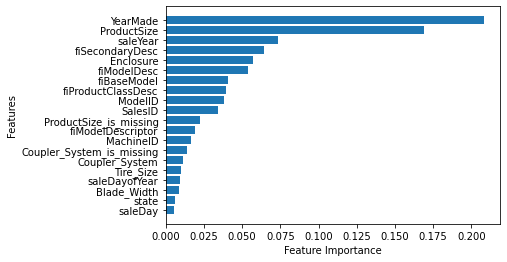

In [85]:
plot_features(X_train.columns, ideal_model.feature_importances_)